#Pruebas modelos (Only PVPC)

##Activación para Colab

In [0]:
#LMG: Variable para controlar si estamos en Colab o no y aplicar a las celdas:
inColab = True

En la siguiente celda, montamos la carpeta personal del Drive en Colab en caso de estar en este entorno. Pedirá un código al que se accede desde el enlace que facilita.

In [5]:
#LMG: Para Google CoLab tener el repo de Drive:
if inColab:
  from google.colab import drive
  drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Carga de librerías y preparación de datos

Antes de preparar todo, elegimos el modelo a utilizar:

In [0]:
useDense = True
useLSTM = False

Ahora pasamos a la carga de librerías y preparación de datos:

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras.backend as K
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import SGD
from keras.regularizers import l2

In [148]:
#LMG: Para CoLab en sample_data:
if inColab:
  data_consumo = pd.read_csv("/content/drive/My Drive/TFM/data/data_total.csv")
else:
  data_consumo = pd.read_csv("data_total.csv")
  
data_consumo.head()

,Unnamed: 0,Unnamed: 0.1,fecha,PVPC_DEF,PVPC_2_PED_NOC,PVPC_ELEC_NOC,date_timestamp,Demanda,Eolica,Nuclear,Solar,Solar_Fotovoltaica,Solar_Termica,Termica_Renovable,Prevista,Programada,date_day,Brent_price,Holiday,Precio de Regulación Secundaria subir,Precio de Regulación Secundaria bajar,Precio mercado SPOT Diario_x,Demanda real,Generación prevista Solar,Saldo total interconexiones programa p48,Generación programada P48 Exportación Portugal,Generación programada P48 Exportación Francia,Generación programada P48 Importación Portugal,Generación programada P48 Importación Francia,Precio SPOT PT,Precio SPOT FR,PVPC-target
0,0,0,2015-10-01 00:00:00+02:00,117.77,69.49,71.88,1.443650e+09,24984.666667,1003.666667,6012.833333,402.166667,33.0,368.500000,580.166667,24691.833333,24517.0,2015-10-01,47.48,0.0,61.18,NaN,56.65,25305.0,267.6,182.4,-606.6,NaN,NaN,1200.0,56.65,38.56,123.30
1,1,1,2015-10-01 01:00:00+02:00,117.09,68.21,65.57,1.443654e+09,23550.833333,899.000000,6013.166667,174.833333,33.0,141.333333,584.166667,23440.000000,23169.0,2015-10-01,47.48,0.0,59.59,NaN,53.50,23959.0,195.7,-269.5,-1112.5,NaN,NaN,1200.0,53.50,31.27,121.98
2,2,2,2015-10-01 02:00:00+02:00,114.59,65.34,62.53,1.443658e+09,22648.166667,927.500000,6013.500000,103.833333,33.0,70.666667,585.833333,22521.166667,22437.0,2015-10-01,47.48,0.0,56.27,49.13,49.69,22873.0,202.1,94.0,-951.0,NaN,NaN,1200.0,49.69,30.66,126.70
3,3,3,2015-10-01 03:00:00+02:00,116.60,66.53,63.40,1.443661e+09,22203.833333,935.666667,6013.000000,102.000000,33.0,69.000000,588.500000,22335.333333,22281.0,2015-10-01,47.48,0.0,45.99,45.50,49.10,22550.0,61.3,319.7,-846.3,NaN,NaN,1200.0,49.10,29.14,131.63
4,4,4,2015-10-01 04:00:00+02:00,122.07,71.03,67.37,1.443665e+09,21987.833333,900.833333,6014.166667,101.666667,33.0,68.166667,589.000000,22177.833333,21910.0,2015-10-01,47.48,0.0,52.28,49.13,51.25,22017.0,45.1,405.5,-760.5,NaN,NaN,1200.0,51.25,29.40,134.73


In [149]:
data = data_consumo[['PVPC_DEF']]

data.head()

,PVPC_DEF
0,117.77
1,117.09
2,114.59
3,116.60
4,122.07


Generamos el dataset como secuencias de precio:

In [0]:
# split a sequence into samples
def split_sequence(sequence, n_steps):
  X = list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x = sequence[i:end_ix,:]
    X.append(seq_x)

  return np.array(X)

In [151]:
split_steps = 10
data_processed = split_sequence(data.to_numpy()[:,0:1], split_steps)
x_data = data_processed[:,:-1,0]
y_data = data_processed[:,-1]
# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.33, shuffle=False)

#Convert NaN values to 0:
x_train = np.nan_to_num(x_train)
x_valid = np.nan_to_num(x_valid)
y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)

print('Xtrain_dim:', x_train.shape)
print('Ytrain_dim:', y_train.shape)

Xtrain_dim: (20465, 9)
Ytrain_dim: (20465, 1)


Veamos cómo queda:

In [152]:
x_train_DF = pd.DataFrame(x_train)
x_train_DF.head()

,0,1,2,3,4,5,6,7,8
0,117.77,117.09,114.59,116.60,122.07,125.31,130.70,135.69,131.02
1,117.09,114.59,116.60,122.07,125.31,130.70,135.69,131.02,130.51
2,114.59,116.60,122.07,125.31,130.70,135.69,131.02,130.51,128.74
3,116.60,122.07,125.31,130.70,135.69,131.02,130.51,128.74,126.96
4,122.07,125.31,130.70,135.69,131.02,130.51,128.74,126.96,124.86


In [153]:
y_train_DF = pd.DataFrame(y_train)
y_train_DF.head()

,0
0,130.51
1,128.74
2,126.96
3,124.86
4,119.25


Por último, generamos funciones y variables de utilidad a lo largo de todos los modelos:

In [0]:
def rmse (y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))

##Ejemplo de NN

Red neuronal densa como punto de partida.

###Preparación y entrenamiento

Primero, estandarizamos los **datos de entrenamiento**:

In [155]:
if useDense:
  scaler = MinMaxScaler()
  x_train_data = scaler.fit_transform(x_train)
  y_train_data = scaler.fit_transform(y_train)
  x_valid_data = x_valid
  y_valid_data = y_valid

  print('Entrenamiento:',x_train_data.shape, y_train_data.shape)
  print('Test:',x_valid_data.shape, y_valid_data.shape)

Entrenamiento: (20465, 9) (20465, 1)
Test: (10080, 9) (10080, 1)


Por último, definimos los tamaños de nuestra red y algunas variables adicionales

In [0]:
if useDense:
  batch_size = 5
  num_var = x_train_data.shape[1]
  hidden_size = 20
  output_size = y_train_data.shape[1]

###Modelo

In [161]:
if useDense:
  # define model
  model = Sequential()
  model.add(Dense(hidden_size, 
                  activation='relu',
                  input_shape=(num_var,),
                  kernel_regularizer=l2(1e-2)))
  model.add(Dropout(0.2))
  model.add(Dense(hidden_size, 
                  activation='relu',
                  kernel_regularizer=l2(1e-2)))
  model.add(Dropout(0.2))
  model.add(Dense(output_size,
                  activation='linear',
                  kernel_regularizer=l2(1e-2)))

  # compile mode
  #opt = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
  opt='adam'
  model.compile(optimizer=opt, loss='mse', metrics=['mse',rmse,'mae','mape'])
  print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 20)                200       
_________________________________________________________________
dropout_22 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_23 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 21        
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________
None


##Ejemplo de LSTM

Basado en el ejemplo completo que está explicado en https://adventuresinmachinelearning.com/keras-lstm-tutorial/

###Preparación y entrenamiento

In [130]:
if useLSTM:
  scaler = MinMaxScaler()
  x_train_data = scaler.fit_transform(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
  y_train_data = scaler.fit_transform(y_train)
  
  x_valid_data = scaler.fit_transform(x_valid).reshape((x_valid.shape[0], x_valid.shape[1], 1))
  y_valid_data = scaler.fit_transform(y_valid)

  print('Entrenamiento:',x_train_data.shape, y_train_data.shape)
  print('Test:',x_valid_data.shape, y_valid_data.shape)

Entrenamiento: (20465, 9, 1) (20465, 1)
Test: (10080, 9, 1) (10080, 1)


Definimos los tamaños de nuestra red y algunas variables adicionales:

En nuestro caso, la entrada va a ser de *1* **x** *nº de datos tomados* **x** *nº de variables independientes*, siendo:

- batch_size, para cada instante tomamos los datos en paquetes.
- nº de datos tomados o num_steps, esto es, en el análisis secuencial cada registro energético completo con el que contamos, o en términos más coloquiales, cuántas filas del dataset se tienen en cuenta .
- nº de variables independientes o num_var, cada registro en los datos de entrada, o en términos más coloquiales, cada columna del dataset.

Además:

- hidden_size, número de unidades en cada célula del LSTM.

- A la salida, tenemos los tres valores a estimar.

In [0]:
if useLSTM:
  batch_size = 16
  num_steps = split_steps - 1
  num_var = x_train_data.shape[2]
  hidden_size = 10
  output_size = y_train_data.shape[1]

###Modelo

A la capa LSTM se le pasa cada vez un instante, siendo el primero el t1, el segundo el t2, etc.

Respecto al ejemplo en la página, hemos:
- Quitado el embedding inicial, ya que no necesitamos codificar la entrada (ya son valores en sí mismos).
- Cambiado el hidden-layer-size. En la página dicen que se suele poner al tamaño de entrada de cada registro. Viene a ser el símil de unidades en una capa densa.
- Dejado una única capa LSTM.
- Eliminado el dropout.
- TimeDistributed usa una capa densa para cada step del entrenamiento. La quitamos también y dejamos la densa exclusivamente, ya que hace la salida muy grande.

Así:


In [120]:
if useLSTM:
  # define model
  model = Sequential()
  model.add(LSTM(hidden_size, 
                 activation='relu',
                 input_shape=(num_steps,num_var),
                 kernel_regularizer=l2(1e-2)))
  model.add(Dropout(0.2))
  model.add(Dense(output_size,
                 activation='relu',
                 kernel_regularizer=l2(1e-2)))

  # compile mode
  opt = SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
  model.compile(optimizer=opt, loss='mse', metrics=['mse',rmse,'mae','mape'])
  print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dropout_19 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


##Entrenamiento

Entrenamos el modelo seleccionado:

DENSE
Epoch 1/5
20465/20465 [==============================] - 8s 369us/step - loss: 0.0411 - mean_squared_error: 0.0125 - rmse: 0.0753 - mean_absolute_error: 0.0753 - mean_absolute_percentage_error: 10293.5467
Epoch 2/5
20465/20465 [==============================] - 6s 281us/step - loss: 0.0084 - mean_squared_error: 0.0082 - rmse: 0.0672 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 12828.2854
Epoch 3/5
20465/20465 [==============================] - 6s 281us/step - loss: 0.0086 - mean_squared_error: 0.0083 - rmse: 0.0675 - mean_absolute_error: 0.0675 - mean_absolute_percentage_error: 14455.6094
Epoch 4/5
20465/20465 [==============================] - 6s 286us/step - loss: 0.0086 - mean_squared_error: 0.0084 - rmse: 0.0676 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 13995.2915
Epoch 5/5
20465/20465 [==============================] - 6s 279us/step - loss: 0.0085 - mean_squared_error: 0.0083 - rmse: 0.0675 - mean_absolute_error: 0.0675 - mean_absolut

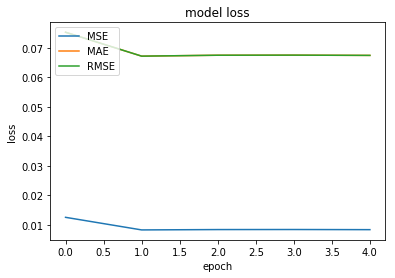

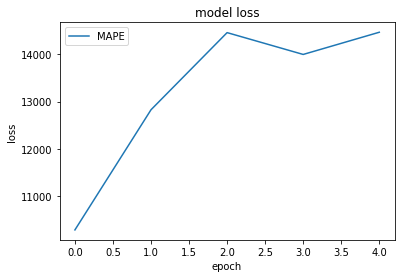

In [162]:
if useDense:
  print('DENSE')
  history_train = model.fit(x_train_data, y_train_data, 
                            epochs=5, 
                            batch_size=batch_size, 
                            shuffle=False,
                            verbose=1)

if useLSTM:
  print('LSTM')
  history_train = model.fit(x_train_data, y_train_data, 
                            epochs=20, 
                            batch_size=batch_size, 
                            shuffle=False,
                            verbose=1)

# summarize history for loss, MAPE in a different scale than the others
plt.plot(history_train.history['mean_squared_error'])
plt.plot(history_train.history['mean_absolute_error'])
plt.plot(history_train.history['rmse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MSE','MAE','RMSE'], loc='upper left')
plt.show()

plt.plot(history_train.history['mean_absolute_percentage_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['MAPE'], loc='upper left')
plt.show()

High MAPE: I think it's because we are calling MinMaxScaler with a range of 0-1: scaler = MinMaxScaler(feature_range=(0, 1)) dataset = scaler.fit_transform(dataset) This guarantees that the minimum value of y_true will be 0. Because it can't divide by 0 it has to treat 0 as K.epsilon, returning a large number instead of infinity. – reductionista May 30 at 22:13 
You are right, I am using that standardization, so another solution would be to use mae since in the [0-1] domain is equivalent to mape.

##Test

Para el test:

In [163]:
if useDense:
  scores_test = model.evaluate(x_valid_data, y_valid_data, batch_size=batch_size, verbose=1)

if useLSTM:
  scores_test = model.evaluate(x_valid_data, y_valid_data, batch_size=batch_size, verbose=1)

  # summarize loss
  for element in range(len(scores_test)):
    print("%s: %.2f" % (model.metrics_names[element], scores_test[element]))

10080/10080 [==============================] - 2s 203us/step


In [164]:
if useDense:
  x_valid_data_DF = pd.DataFrame(x_valid_data)
  
if useLSTM:
  x_valid_data_DF = pd.DataFrame(x_valid_data[:,:,0])
  
x_valid_data_DF.head()

,0,1,2,3,4,5,6,7,8
0,122.04,122.17,122.72,121.99,119.90,119.36,119.52,119.58,119.55
1,122.17,122.72,121.99,119.90,119.36,119.52,119.58,119.55,122.00
2,122.72,121.99,119.90,119.36,119.52,119.58,119.55,122.00,124.43
3,121.99,119.90,119.36,119.52,119.58,119.55,122.00,124.43,125.70
4,119.90,119.36,119.52,119.58,119.55,122.00,124.43,125.70,125.63


In [165]:
if useDense:
  y_valid_data_DF = pd.DataFrame(y_valid_data)
  
if useLSTM:
  y_valid_data_DF = pd.DataFrame(y_valid_data)
  
y_valid_data_DF.head()

,0
0,122.00
1,124.43
2,125.70
3,125.63
4,123.66


Valores que tratamos que sean iguales:

In [143]:
print(y_valid_data[0:9])

[[122.  ]
 [124.43]
 [125.7 ]
 [125.63]
 [123.66]
 [127.2 ]
 [126.91]
 [125.99]
 [126.33]]


In [166]:
if useDense:
  print('DENSE')
  prediction = model.predict(x_valid_data[0:9,:], verbose=1)

if useLSTM:
  print('LSTM')
  prediction = model.predict(x_valid_data[0:9,:,:], verbose=1)

print(prediction)

DENSE
9/9 [==============================] - 1s 59ms/step
[[0.39684668]
 [0.3968482 ]
 [0.39684963]
 [0.3968506 ]
 [0.39685026]
 [0.39684793]
 [0.3968455 ]
 [0.39684266]
 [0.3968395 ]]


In [167]:
#Pesos
for layer in model.layers:
    print(layer.get_weights()[0])

[[-3.76487951e-34  2.37455599e-34 -3.52770286e-34 -3.53569851e-34
  -1.90378312e-04 -1.56378024e-04  4.50724896e-34 -2.39710556e-04
  -2.38349923e-04 -4.08751337e-04 -2.13698047e-04  2.93875264e-34
  -1.94135762e-04 -4.22328718e-34  3.43373150e-34 -1.90500626e-34
  -2.44989484e-34 -3.06259303e-34 -4.65479049e-34 -3.33702366e-04]
 [-2.08861882e-34  9.31734819e-36 -5.17303472e-34 -7.16469776e-35
  -1.99986767e-04 -1.58793322e-04 -4.55562560e-34 -2.43901362e-04
  -2.44419469e-04 -4.22369369e-04 -2.08150261e-04  3.03607553e-34
  -1.99895992e-04 -2.94596046e-35  2.41597471e-34  3.49360021e-34
   2.98378050e-34 -1.44330778e-34 -4.38571203e-35 -3.36988189e-04]
 [ 4.73354034e-34  1.75924760e-34 -3.39356793e-34 -3.93915687e-34
  -2.12441781e-04 -1.72775079e-04  3.27988179e-34 -2.52352678e-04
  -2.45726784e-04 -4.11060115e-04 -2.14181244e-04 -3.38022974e-34
  -2.09771082e-04  4.40908324e-34 -2.70323523e-34 -6.40308303e-35
   2.49589708e-34 -3.74727510e-34  2.84319252e-34 -3.48728237e-04]
 [ 1.69

IndexError: ignored

In [0]:
#Biases
for layer in model.layers:
    print(layer.get_weights()[1])